# Recurrent LSTM model - Eksperimenter med FED data

- **Problem:** Kan jeg med ML finde FED overskrifter, som giver 10 eller flere strategilinjer? Mine input data er FED data, hvor jeg har samlet en overskrift og det tilhørende *antal* linjer strategi hørende til overskriften. Dette er et binary problem: over eller under 10 linjer
- **Succes er** Jeg vil se hvor mange af de store (10 eller flere strategilinjer) som modellen kan finde i test data. JEg håber på halvdelen, men er usikker, for jeg kan ikke selv se et mønster ...
- **Evaluering** Modellen evalueres ved at jeg deler data op i train, validering og test. train og validering opdeles atomatisk af Keras
- **Data** hentes ud af FED i en tekst-fil. Den videre behandling sker i en Access-database og i et regneark. Input gemmes til sidst i et regneark
- **Baseline** Selv den bedste model har ikke rigtigt gjort det godt ind til nu, der er nok ikke system i data? Reelt kan den ikke skelne de to klasser, se histogrammet nederst ...
- **Optimering vs generalisering** Modellen overfitter ret hurtigt, uden at den egentligt på noget tidspunkt bliver god ...
- **Tuning hyper pametre** Jeg prøver med flere og færre lag, typer af lag, dropout, parametre mv, men det virker ikke meget bedre ... 

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. Og den timsvarende omsættelse til inddata til modellen.

![title](FEDentry.GIF)
![title](FEDentry2.GIF)

### Konklusion
- x

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
StorEr = 10
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values
labels = np.asarray([1*(NumLines[i]>=StorEr) for i in range(len(NumLines))])

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 90000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
labels_train = labels[:i]
labels_test  = labels[i:]
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [3]:
# laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Stop sætninger efter dette antal ord
maxlen = 50

# sætninger laves til tekst-vektor og der "paddes"
sequences = tokenizer.texts_to_sequences(texts_train)
data_train = pad_sequences(sequences, maxlen=maxlen)
sequences = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences, maxlen=maxlen)

# labels laves til vektor
labels_train = np.asarray(labels_train).astype('float32')
labels_test = np.asarray(labels_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(90000, 50)
(10867, 50)
(90000,)
(10867,)


In [5]:
#from keras import models
#from keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, LSTM
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 8)             80000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 85,281
Trainable params: 85,281
Non-trainable params: 0
_________________________________________________________________


In [6]:
NumEpochs = 10
history = model.fit(data_train, labels_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.1)

Train on 81000 samples, validate on 9000 samples
Epoch 1/10
81000/81000 [==============================] - 22s 271us/step - loss: 0.1875 - acc: 0.9592 - val_loss: 0.1487 - val_acc: 0.9640
Epoch 2/10
81000/81000 [==============================] - 20s 250us/step - loss: 0.1354 - acc: 0.9622 - val_loss: 0.1217 - val_acc: 0.9644
Epoch 3/10
81000/81000 [==============================] - 20s 249us/step - loss: 0.1217 - acc: 0.9626 - val_loss: 0.1262 - val_acc: 0.9649
Epoch 4/10
81000/81000 [==============================] - 20s 247us/step - loss: 0.1177 - acc: 0.9630 - val_loss: 0.1278 - val_acc: 0.9650
Epoch 5/10
81000/81000 [==============================] - 20s 247us/step - loss: 0.1147 - acc: 0.9632 - val_loss: 0.1247 - val_acc: 0.9647
Epoch 6/10
81000/81000 [==============================] - 20s 250us/step - loss: 0.1137 - acc: 0.9634 - val_loss: 0.1230 - val_acc: 0.9653
Epoch 7/10
81000/81000 [==============================] - 20s 247us/step - loss: 0.1115 - acc: 0.9640 - val_loss: 0.1

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

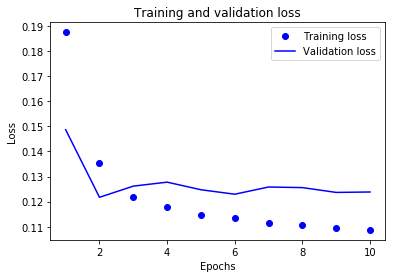

In [9]:
# plotter historikken for 'loss' og 'accuracy'
accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

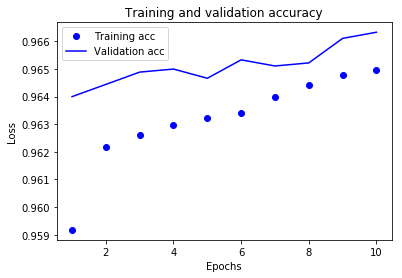

In [10]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [11]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)

In [12]:
# finder ud af hvor stor en del store, som er fundet
print('Antal store i datasættet:    ', sum(labels_test))
NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.4 and labels_test[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     387.0
antal estimeret af modellen:  30
Modellens præcision:          8.0 %


In [13]:
# Gennemsnittet for rigtig og forkert

print(' Gennemsnit for test stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels_test[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels_test[i]]))

 Gennemsnit for test stor og lille
0.18939327
0.03143148


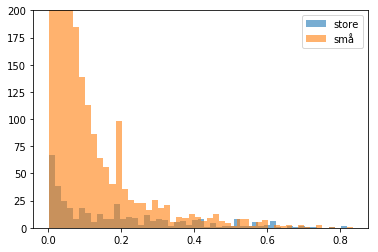

In [14]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_test[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_test[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 200])

plt.show()

In [15]:
# hvilke tekster de forskellige typer består af
print('SANDE i test-sættet, som har SMÅ predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==1 and predictions[i] < 0.05:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()
        
print('SANDE i test-sættet, som har STORE predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==1 and predictions[i] > 0.5:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()

print('FALSKE i test-sættet, som har STORE predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==0 and predictions[i] > 0.5:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()

SANDE i test-sættet, som har SMÅ predictions (men burde være store!):
----------------------------------------
Lines Predict Text
   10  0.0301  fast fjeder bremse
   10  0.0371  ATC kan ikke indkobles..
   12  0.0031  Materielfejl ET, 4 døre aflåste. Tgf beder om at ændret skilte til hhv. forreste/bagerste sæt aflåst
   10  0.0166  Står i stå i neutralsektion ilige før Ro Der skiftes strømaftager
   11  0.0272  Materielmangel Sverige:
   17  0.0212  Materielfejl, holder nu koblet i Ringsted med fejl, kan ikke få traktion på toget.
   10  0.0165  Signalfejl... SMUTO-anlægget i Kac gået ned...
   10  0.0082  Disponering DSB. Det har ikke været muligt, at komme til/fra Askekassen i nat pga. den har været ube
   10  0.0048  Politi. Tgf. melder der står en mistænklige kuffert. Lkf. rangere den i sp.21
   19  0.0079  Materielfejl MG : koldt klima i Førerrum mod Vest
   13  0.0337  Disponering DSB/Passagerforhold. Manglende pladser i flere tog
   10  0.0126  Disponering Materiel
   11  0.003

UHA UHA, alt for mange af de sande har en værdi tæt på 0 ...